In [1]:
# Setup the working directory for the notebook
import notebook_setup
from sirf_exercises import cd_to_working_dir
cd_to_working_dir('PET', 'reconstruct_measured_data')

In [2]:
import os
import sys
import matplotlib.pyplot as plt
from sirf.Utilities import show_2D_array, examples_data_path
from sirf.STIR import *
from sirf_exercises import exercises_data_path

# Find the path to the data directory
data_path = exercises_data_path('PET', 'mMR', 'NEMA_IQ')

import sirf.STIR as pet
# turn off verbosity
pet.set_verbosity(0)
pet.AcquisitionData.set_storage_scheme("memory")

If the above failed, it probably means that `convertSiemensInterfileToSTIR.sh` wasn't installed. The following line might help.

In [3]:
#%% set filenames 
# input files
list_file = os.path.join(data_path, '20170809_NEMA_60min_UCL.l.hdr')
norm_file = 'norm.n.hdr'
attn_file = 'umap.v.hdr'
# output filename prefixes
sino_file = 'sino'
# %ls

In [4]:
# redirect STIR messages to some files
# you can check these if things go wrong
msg_red = MessageRedirector('info.txt', 'warnings.txt')

# Creating sinograms from listmode data
Modern PET scanners can store data in listmode format. This is essentially a long list of all events detected by the scanner. We are interested here in the *prompts* (the coincidence events) and the *delayed events* (which form an estimate of the *accidental coincidences* in the prompts.

We show how to histogram the prompts into a sinogram etc.

## First create a template for the sinogram
This template is used to specify the sizes of the output sinogram.

It is often the case in PET that we use sinograms with "larger" bins, i.e. combine data from several detector pairs into a single bin. This reduces size of the final sinogram, and decreases computation time. The terminology here is somewhat complicated, but *span* uses "axial compression" (higher span means smaller data size), *max_ring_diff* specifies the maximum ring difference to store, and *view_mash_factor* can be used to reduce the number of views (or azimutal angles). You could check the [STIR glossary](http://stir.sourceforge.net/documentation/STIR-glossary.pdf) for more detail.

Siemens uses span=11, max_ring_diff=60 and view_mash_factor=1 for the mMR. Here we will use a smaller data size to reduce computation time for the exercise. Feel free to change these numbers (if you know what you are doing...). (Note that the list mode data stores data only up to ring difference 60, even though the scanner has 64 rings).

In [5]:
template_acq_data = AcquisitionData('Siemens_mMR', span=11, max_ring_diff=15, view_mash_factor=2)
template_acq_data.write('template.hs')

In [6]:
# create listmode-to-sinograms converter object
lm2sino = ListmodeToSinograms()

# set input, output and template files
lm2sino.set_input(list_file)
lm2sino.set_output_prefix(sino_file)
lm2sino.set_template('template.hs')

In [7]:
# set timing interval (in secs) since start of acquisition
# (the listmode file provided is for 1 hour).
# you can vary this to see the effect on noise. Increasing it will mean somewhat longer
# processing time in the following steps (but not in the reconstruction).
lm2sino.set_time_interval(0, 600)  # 0 - 600 is the first 10 minutes
# set up the converter
lm2sino.set_up()
# create the prompts sinogram
lm2sino.process()


INFO: CListModeDataECAT8_32bit: opening file /mnt/f/Vaggelis_Finden/SIRF-Exercises/data/PET/mMR/NEMA_IQ/20170809_NEMA_60min_UCL.l
15500000 events stored


Processing time frame 1

Number of prompts stored in this time period : 15566737
Number of delayeds stored in this time period: 0
Last stored event was recorded before time-tick at 600 secs
Total number of counts (either prompts/trues/delayeds) stored: 15566737

This took 22.52s CPU time.


## Check the prompts sinograms
The 3D PET data returned by `as_array` are organised by 2D sinogram. The exact order of the sinograms
is complicated for 3D PET, but SIRF orders them by *segment* (roughly: average ring difference). The first
segment corresponds to "segment 0", i.e. detector pairs which are (roughly) in the same 
detector ring. For a clinical scanner with `N` rings, there will be `2N-1` (2D) sinograms in segment 0. See also information in the [image_creation_and_simulation notebook](image_creation_and_simulation.ipynb).

num prompts: 15566737
acquisition data dimensions: 357x126x344
You may need to close Figure 1 window to continue...


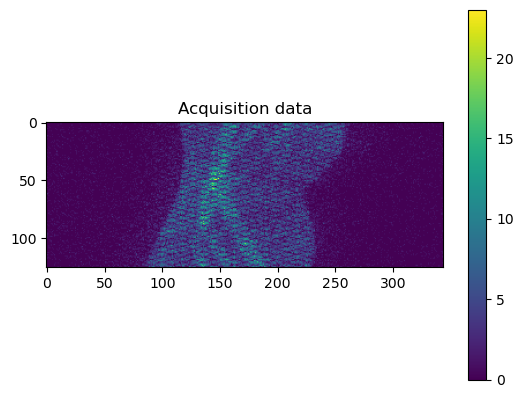

In [8]:
# get access to the sinograms
acq_data = lm2sino.get_output()
# copy the acquisition data into a Python array
acq_array = acq_data.as_array()[0,:,:,:]  # first index is for ToF, which we don't have here
# how many counts total?
print('num prompts: %d' % acq_array.sum())
# print the data sizes. 
print('acquisition data dimensions: %dx%dx%d' % acq_array.shape)
# use a slice number for display that is appropriate for the NEMA phantom
# showing a "middle" sinogram in segment 0.
z = 71
show_2D_array('Acquisition data', acq_array[z,:,:])

In [9]:
nxny = (127, 127)
image = acq_data.create_uniform_image(1.0, nxny)

In [10]:
attn_image = ImageData(attn_file)

In [11]:
# # Get the randoms
import zarr
tmp_randoms = zarr.load("../../../../data/working_folder/PET/reconstruct_measured_data/nema_randoms.zarr")
randoms = acq_data*0.
randoms.fill(tmp_randoms)

# randoms = lm2sino.estimate_randoms()

In [12]:
acq_model = AcquisitionModelUsingRayTracingMatrix()
acq_model.set_num_tangential_LORs(10)

In [13]:
asm_norm = AcquisitionSensitivityModel(norm_file)

# create attenuation factors
asm_attn = AcquisitionSensitivityModel(attn_image, acq_model)
# converting attenuation image into attenuation factors (one for every bin)
asm_attn.set_up(acq_data)
ac_factors = acq_data.get_uniform_copy(value=1)
print('applying attenuation (please wait, may take a while)...')
asm_attn.unnormalise(ac_factors)
asm_attn = AcquisitionSensitivityModel(ac_factors)

Reading manufacturer PET normalisation file from norm.n.hdr
applying attenuation (please wait, may take a while)...


In [14]:
tmp_scatter = zarr.load("../../../../data/working_folder/PET/reconstruct_measured_data/nema_scatter.zarr")
# tmp_randoms
scatter = acq_data*0.
scatter.fill(tmp_scatter)

# # Get the randoms
# randoms = lm2sino.estimate_randoms()

# scatter_estimator = ScatterEstimator()
# scatter_estimator.set_input(acq_data)
# scatter_estimator.set_attenuation_image(attn_image)
# scatter_estimator.set_randoms(randoms)
# scatter_estimator.set_asm(asm_norm)
# # invert attenuation factors to get the correction factors,
# # as this is unfortunately what a ScatterEstimator needs
# acf_factors=acq_data.get_uniform_copy()
# acf_factors.fill(1/ac_factors.as_array())
# scatter_estimator.set_attenuation_correction_factors(acf_factors)
# scatter_estimator.set_output_prefix(sino_file + '_scatter')
# scatter_estimator.set_num_iterations(3)
# scatter_estimator.set_up()
# scatter_estimator.process()
# scatter_estimate = scatter_estimator.get_output()

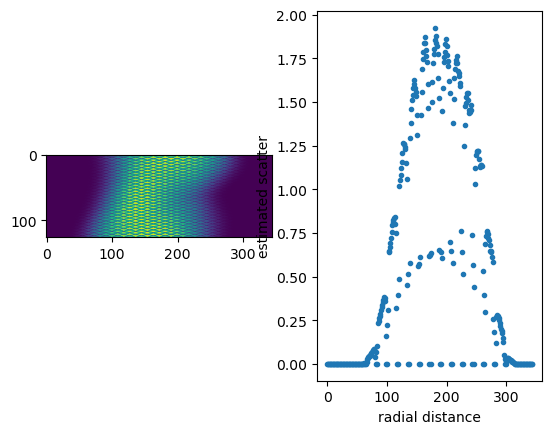

In [15]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(scatter.as_array()[0,z,:,:],clim=None)
plt.subplot(1,2,2)
plt.plot(scatter.as_array()[0,z,0,:],'.')
plt.xlabel('radial distance')
plt.ylabel('estimated scatter')
plt.show()

In [16]:
# chain attenuation and ECAT8 normalisation
asm = AcquisitionSensitivityModel(asm_norm, asm_attn)
asm.set_up(acq_data)
acq_model.set_acquisition_sensitivity(asm)

### Randoms and Scatter

In [17]:
eta = randoms + scatter

### Recon using CIL

In [18]:
from cil.optimisation.functions import KullbackLeibler, OperatorCompositionFunction
from cil.optimisation.algorithms import ISTA
from cil.optimisation.utilities import AdaptiveSensitivity, Sensitivity
from cil.optimisation.functions import KullbackLeibler, OperatorCompositionFunction, IndicatorBox
from cil.optimisation.utilities import SequentialSampling

In [19]:
acq_model.set_up(acq_data, image)
mask = acq_model.direct(image.get_uniform_copy(1.0))

tmpf = KullbackLeibler(b=acq_data, eta=eta, mask=mask, backend="numba") 
f1 = OperatorCompositionFunction(tmpf, acq_model)

In [20]:
## form objective
f2 = RelativeDifferencePrior()
f2.set_epsilon(1e-5)
f2.set_penalisation_factor(15.)
f2.set_up(image)

In [21]:
sens = AdaptiveSensitivity(acq_model, delta = 0., iterations = 200)

In [22]:
obj_fun = f1 + f2

In [23]:
trunc = TruncateToCylinderProcessor()
trunc.apply(image)

ista = ISTA(initial = image, f = obj_fun, g = IndicatorBox(lower=0.), preconditioner = sens,
             step_size = 1., 
             update_objective_interval=10, max_iteration=50)
ista.run(verbose=1)

     Iter   Max Iter  Time(s)/Iter            Objective
        0         50         0.000          8.72371e+09
       10         50         8.588          5.99905e+06
       20         50         8.555          5.97529e+06
       30         50         8.557          5.96930e+06
       40         50         8.551          5.96635e+06
       50         50         8.545          5.96476e+06
-------------------------------------------------------
Stop criterion has been reached.



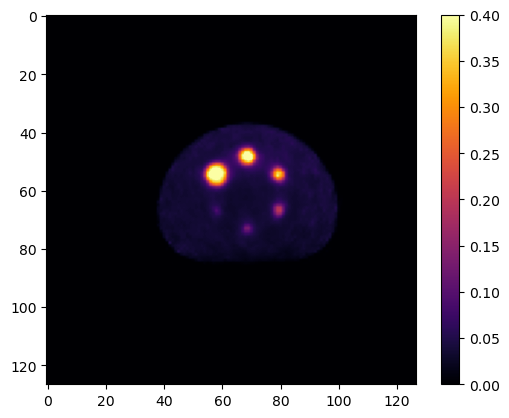

In [25]:
plt.figure()
plt.imshow(ista.solution.as_array()[z], cmap="inferno", vmax=0.4)
plt.colorbar()
plt.show()


In [26]:
acq_model.set_background_term(eta)

In [27]:
# define objective function to be maximized as
# Poisson logarithmic likelihood (with linear model for mean)
obj_fun = make_Poisson_loglikelihood(acq_data)
obj_fun.set_acquisition_model(acq_model)

In [28]:
num_subsets = 21
num_subiterations = 12

recon = OSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)
recon.set_num_subsets(num_subsets)
recon.set_num_subiterations(num_subiterations)

In [29]:
recon.set_up(image)

# set the initial image estimate
recon.set_current_estimate(image)

# reconstruct
print('reconstructing, please wait...')
recon.process()
osem = recon.get_output()

reconstructing, please wait...


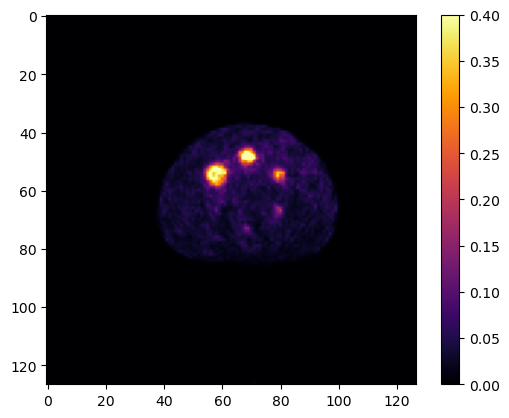

In [22]:
# plt.figure()
# plt.imshow(osem.as_array()[z], cmap="inferno", vmax=0.4)
# plt.colorbar()
# plt.show()


In [19]:
# ## form objective
# f2 = RelativeDifferencePrior()
# f2.set_epsilon(1e-5)
# f2.set_penalisation_factor(15.)
# f2.set_up(image)

In [30]:
obj_fun = make_Poisson_loglikelihood(acq_data)
obj_fun.set_acquisition_model(acq_model)
obj_fun.set_prior(f2)

## reconstructor
recon = OSMAPOSLReconstructor()
recon.set_objective_function(obj_fun)

num_subsets = 1
num_subiterations = 50
recon.set_num_subsets(num_subsets)
recon.set_num_subiterations(num_subiterations)

recon.set_up(image)
recon.set_current_estimate(image)
recon.process()

In [31]:
mlem_rdp = recon.get_output().as_array()

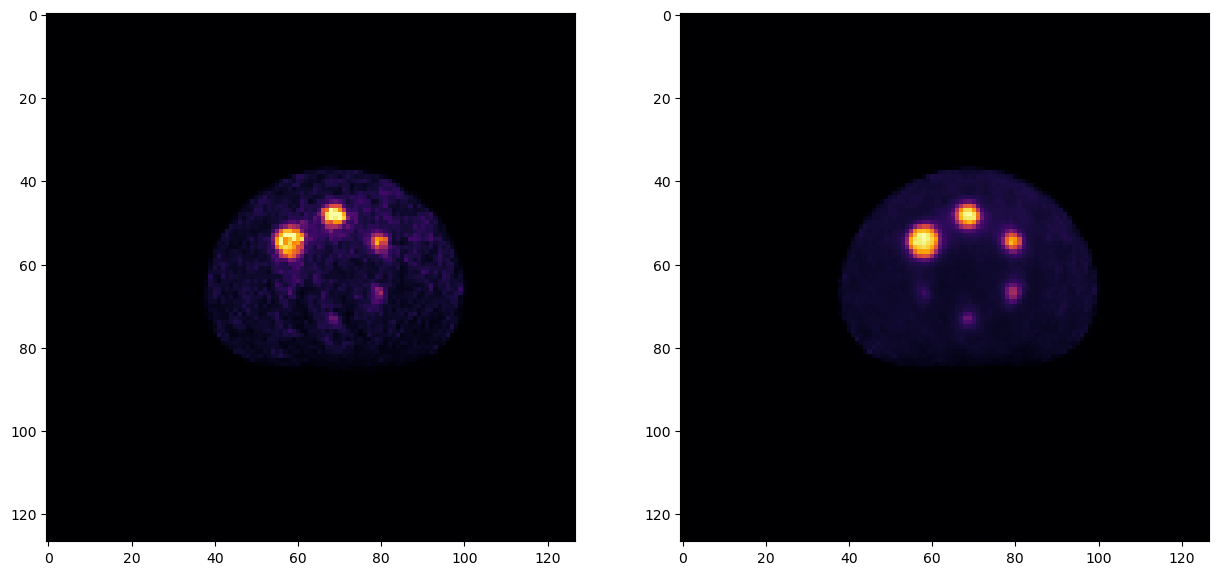

In [46]:
fix, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(osem.as_array()[z], vmax=0.45, cmap="inferno", label="OSEM-SIRF")
ax[1].imshow(mlem_rdp[z], vmax = 0.45, cmap="inferno", label="MLEM-RDP-SIRF")
plt.show()


In [48]:
initial_image = acq_data.create_uniform_image(1.0, nxny)

acq_model.set_up(acq_data, initial_image)
# sens = AdaptiveSensitivity(acq_model, delta = 0., iterations = 200)

In [49]:
trunc = TruncateToCylinderProcessor()
trunc.apply(image)

ista = ISTA(initial = image, f = obj_fun, g = IndicatorBox(lower=0.), preconditioner = sens,
             step_size = -1., 
             update_objective_interval=10, max_iteration=50)
ista.run(verbose=1)

     Iter   Max Iter  Time(s)/Iter            Objective
        0         50         0.000         -8.84194e+09
       10         50         5.234         -3.61013e+06
       20         50         5.251         -3.58490e+06
       30         50         5.238         -3.57833e+06
       40         50         5.258         -3.57512e+06
       50         50         5.264         -3.57341e+06
-------------------------------------------------------
Stop criterion has been reached.



In [50]:
obj_fun(recon.get_output()), ista.objective[-1]

(-3572630.75, -3573406.75)

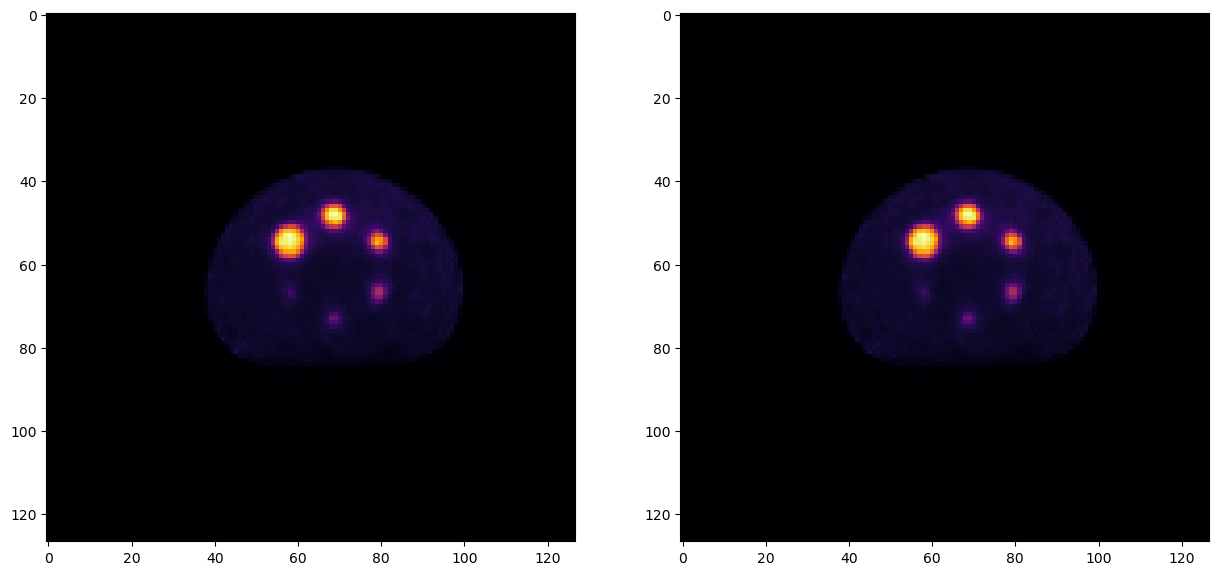

In [51]:
fix, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(recon.get_output().as_array()[z], vmax=0.45, cmap="inferno")
ax[1].imshow(ista.solution.as_array()[z], vmax = 0.45, cmap="inferno")
plt.show()



In [69]:
# asm_norm.shape

In [70]:
data_split = []
eta_split = []
Ai = []
new_acq_data = pet.AcquisitionData('sino_f1g1d0b0.hs')
num_subsets = 42
splitting_method = SequentialSampling(126, num_subsets)


In [78]:
# norm_file

In [74]:
# create attenuation
acq_model_for_attn = pet.AcquisitionModelUsingRayTracingMatrix()
asm_attn = pet.AcquisitionSensitivityModel(attn_image, acq_model_for_attn)
asm_attn.set_up(template)
attn_factors = asm_attn.forward(template.get_uniform_copy(1))
asm_attn = pet.AcquisitionSensitivityModel(attn_factors)

In [80]:
attn_image.shape

(127, 344, 344)

In [76]:
for i in splitting_method.partition_list:
    
    acq_model = AcquisitionModelUsingRayTracingMatrix()
    acq_model.set_num_tangential_LORs(10)

    asm_norm = AcquisitionSensitivityModel(norm_file)
    
    # create attenuation factors
    asm_attn = AcquisitionSensitivityModel(attn_image, acq_model)
    # converting attenuation image into attenuation factors (one for every bin)

    tmp_split_data = new_acq_data.get_subset(i)
    
    asm_attn.set_up(tmp_split_data)
    ac_factors = tmp_split_data.get_uniform_copy(value=1)
    asm_attn.unnormalise(ac_factors)
    asm_attn = AcquisitionSensitivityModel(ac_factors)
    
    # chain attenuation and ECAT8 normalisation
    asm = AcquisitionSensitivityModel(asm_norm, asm_attn)
    asm.set_up(tmp_split_data)
    acq_model.set_acquisition_sensitivity(asm)
    
    acq_model.set_up(tmp_split_data, image)  

    Ai.append(acq_model)


    
# return Ai, data_split, eta_split

Reading manufacturer PET normalisation file from norm.n.hdr


error: ??? "'stir::BinNormalisation setup failed' exception caught at line 406 of /mnt/f/Vaggelis_Finden/SIRF-SuperBuild/build/sources/SIRF/src/xSTIR/cSTIR/stir_x.cpp; the reconstruction engine output may provide more information"

In [61]:
# acq_data.get_subset([0])